In [1]:
import torch as th
from time import time
from params import default_params

# ------------------------- ENVIRONMENTS ---------------------------
from environments.environment_tsp import EnviornmentTSP
# ----------------------------------------------------------------

# ------------------------- NETWORKS -------------------------------
from networks.attention_encoder_decoder import LightAttentionEncoderDecoder
from networks.attention_encoder_decoder import HeavyAttentionEncoderDecoder
from networks.simple_decoder import SimpleDecoder
# ----------------------------------------------------------------

# ------------------------- EXPERIMENTS ----------------------------
from experiments.actor_critic_experiment import ActorCriticExperiment
# ----------------------------------------------------------------

# ------------------------- CONTROLLERS ----------------------
from controllers.ac_controller import ActorCriticController
from controllers.epsilon_greedy_controller import EpsilonGreedyController
# ------------------------------------------------------------------

# ------------------------- LEARNERS --------------------------------
from learners.reinforce_learner import ReinforceLearner
from learners.biased_reinforce_learner import BiasedReinforceLearner
from learners.actor_critic_learner import ActorCriticLearner
from learners.off_policy_actor_critic_learner import OffpolicyActorCriticLearner
from learners.ppo_learner import PPOLearner
# ------------------------------------------------------------------

# -------------------------- GENERATORS ----------------------------
from generators.tsp_generator import TSPGenerator
# ------------------------------------------------------------------

# -------------------------- SOLVERS ----------------------------
from solvers.gurobi_tsp import solve_tsp
# ------------------------------------------------------------------

In [2]:
params = default_params()

# Debugging outputs and plotting during training
params['plot_frequency'] = 10
params['plot_train_samples'] = True
params['debug_messages'] = False
params['print_dots'] = False

# Environment parameters
max_nodes_per_graph = 10
instance = 0
params['env'] = 'tsp'
params['node_dimension'] = 2
params['max_nodes_per_graph'] = max_nodes_per_graph
params['max_episode_length'] = max_nodes_per_graph + 1
params['diff_cities'] = False
# params['diff_sizes'] = False
# params['use_training_set'] = False
# params['training_sizes'] = [5, 6, 7, 8, 9, max_nodes_per_graph]
# params['num_train_instance_per_size'] = 10
params['cities'] = th.load(f"training/tsp/size_{max_nodes_per_graph}/instance_{instance}.pt")

# Runner parameters
max_episodes = 500
rollouts_per_batch = 50
params['max_episodes'] = max_episodes
params['max_steps'] = params['max_episodes'] * params['max_episode_length'] * rollouts_per_batch
params['multi_runner'] = False               
# params['parallel_environments'] = 2  

# Exploration parameters

pct_epsilon_anneal_time = 0.9
params['use_epsilon_greedy'] = True
params['epsilon_anneal_time'] =  pct_epsilon_anneal_time * params['max_steps']
params['epsilon_finish'] = 1E-5
params['epsilon_start'] = 1.0
params['epsilon_decay'] = "linear"
params['entropy_weight'] = 0.1

pct_entropy_anneal_time = 0.9
params['entropy_regularization'] = False
# params['decay_entropy'] = True
# params['entropy_weight_start'] = 1.0
# params['entropy_weight_end'] = 0.001
# params['entropy_anneal_time'] = pct_entropy_anneal_time * params['max_steps']

# Optimization parameters
params['lr'] = 5E-4
params['gamma'] = 0.99
params['batch_size'] = params['max_episode_length'] * rollouts_per_batch
params['grad_norm_clip'] = 1

# Actor-critic parameters
params['value_loss_param'] = 0.1
params['advantage_bias'] = True
params['advantage_bootstrap'] = True
params['offpolicy_iterations'] = 10
params['value_targets'] = 'td'

# PPO parameters
params['ppo_clipping'] = True
params['ppo_clip_eps'] = 0.1

# Network parameters
# params['embedding_dimension'] = 4                                    
# params['n_heads'] = 4               
# params['n_layers'] = 3 
# params['normalization'] = 'batch'
# params['feed_forward_hidden'] = 512      

# Device
# ------------------------- SET DEFAULT DEVICE -------------------
params['device'] = "cuda" if th.cuda.is_available() else "cpu"
th.device(params['device'])
# ----------------------------------------------------------------
# params['device'] = 'cpu'
params['use_tqdm'] = False
params['final_plot'] = False
params['wandb'] = False

print("Device in use: ", params['device'])
print("Epsilon anneal time: ", params['epsilon_anneal_time'])
print("Total transitions: ", params['max_steps'])

Device in use:  cpu
Epsilon anneal time:  247500.0
Total transitions:  275000


/home/tomas/.cache/pypoetry/virtualenvs/tfg-Gt2Gev_N-py3.11/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
model = SimpleDecoder(params=params)
env = EnviornmentTSP(params=params)

# Run experiment
biased_reinforce_experiment = ActorCriticExperiment(params, model, env, BiasedReinforceLearner(model, params))
actor_critic_experiment = ActorCriticExperiment(params, model, env, ActorCriticLearner(model, params))
ppo_experiment = experiment = ActorCriticExperiment(params, model, env, PPOLearner(model, params))

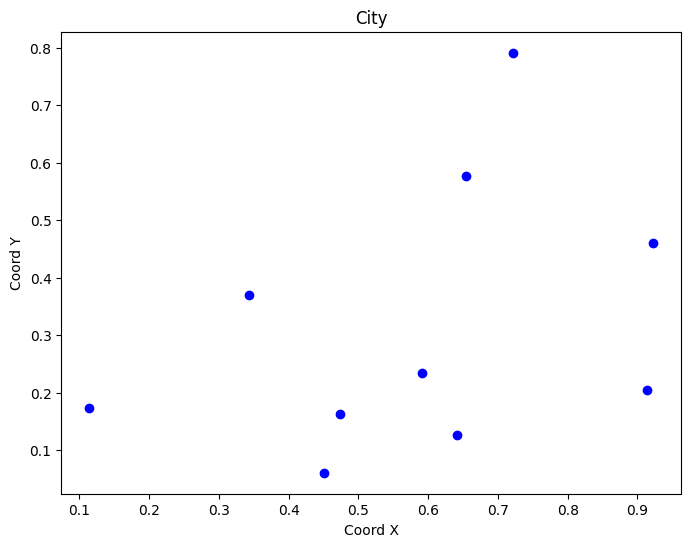

In [17]:
tsp_generator = TSPGenerator()
tsp_generator.plot_instance(params['cities'])

## Optimal Tour

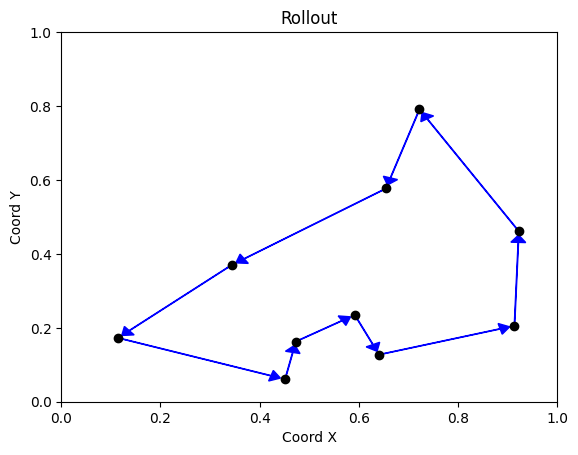

In [5]:
permutation, distance = solve_tsp(params['cities'])
reinforce_experiment.plot_tour(cities=params['cities'], tour=th.tensor(permutation), num_cities=len(permutation) - 1)

In [6]:
print("Permutation: ", permutation)
print("Distance: ", distance)

Permutation:  tensor([0, 4, 6, 9, 8, 1, 2, 7, 3, 5, 0])
Distance:  2.542541489005089


## Reinforce Learner

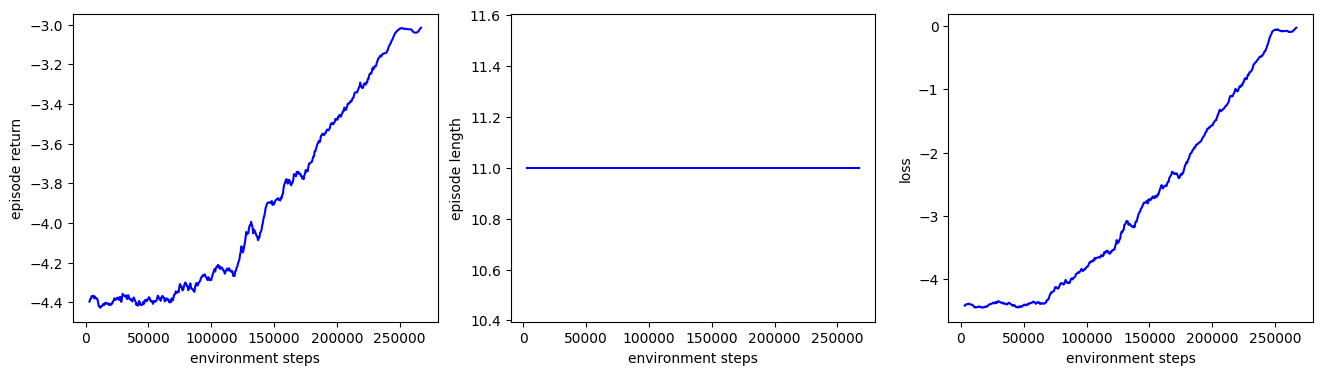

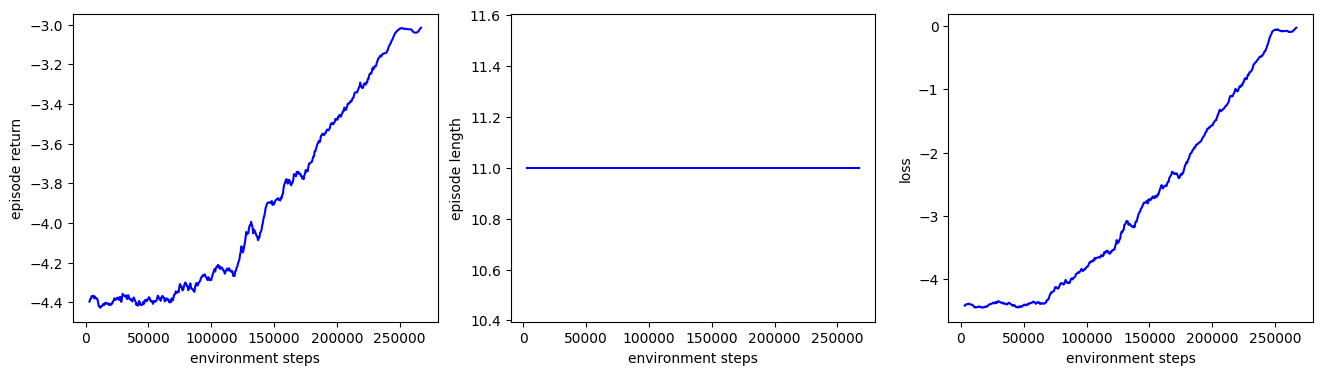

In [7]:
_,_,_,_ = reinforce_experiment.run()

Tour distance: 3.0122697353363037


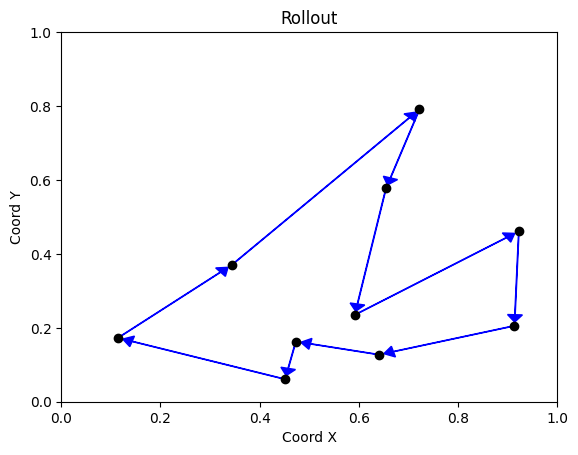

In [8]:
reinforce_experiment.plot_rollout()

## Biased Reinforce Learner

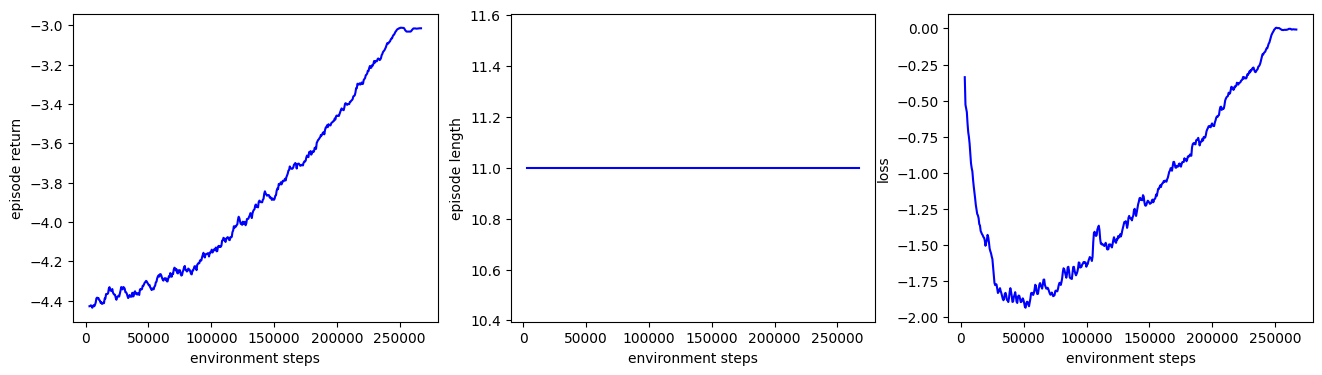

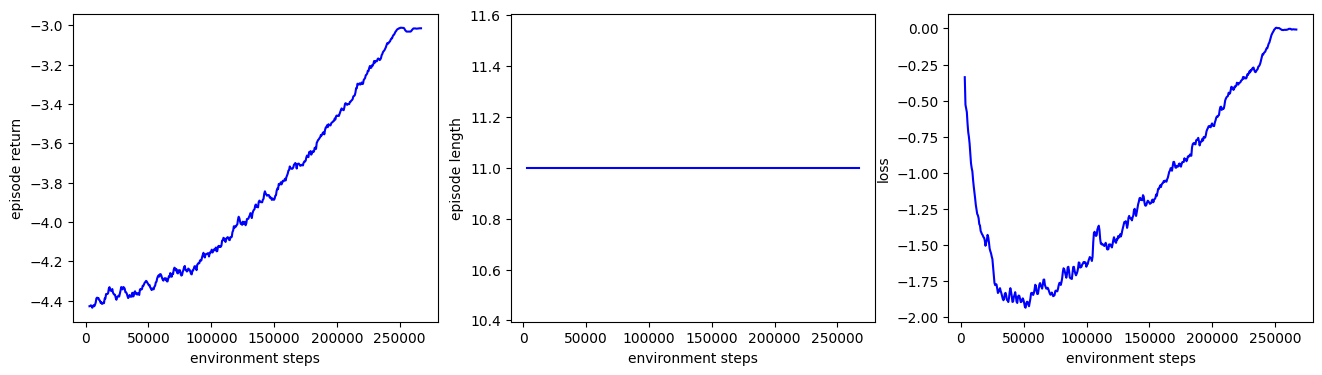

In [9]:
_,_,_,_ = biased_reinforce_experiment.run()

Tour distance: 3.0122697353363037


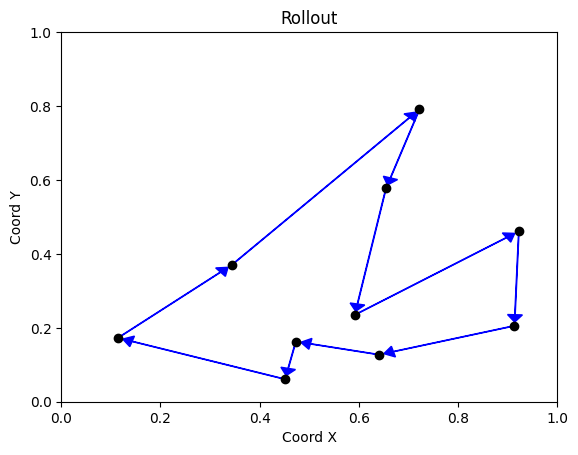

In [10]:
biased_reinforce_experiment.plot_rollout()

## Actor-Critic Learner

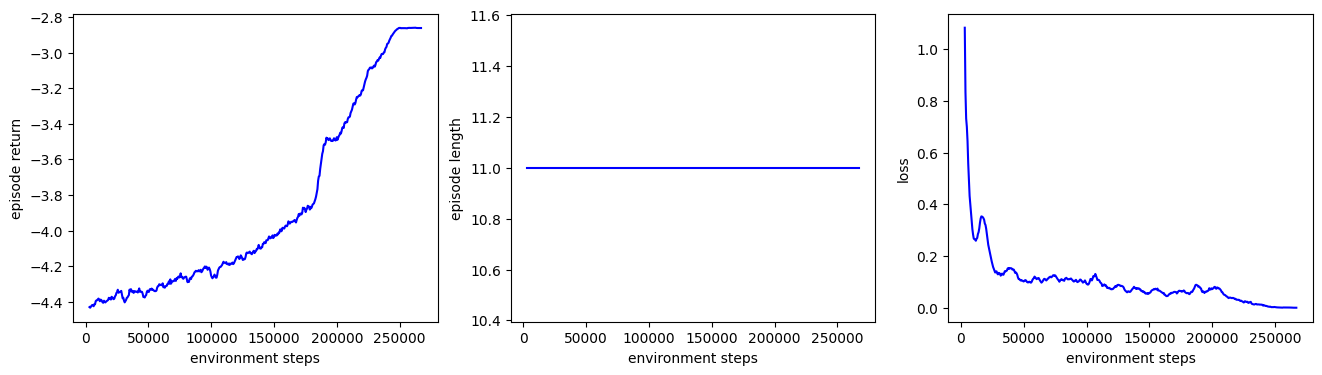

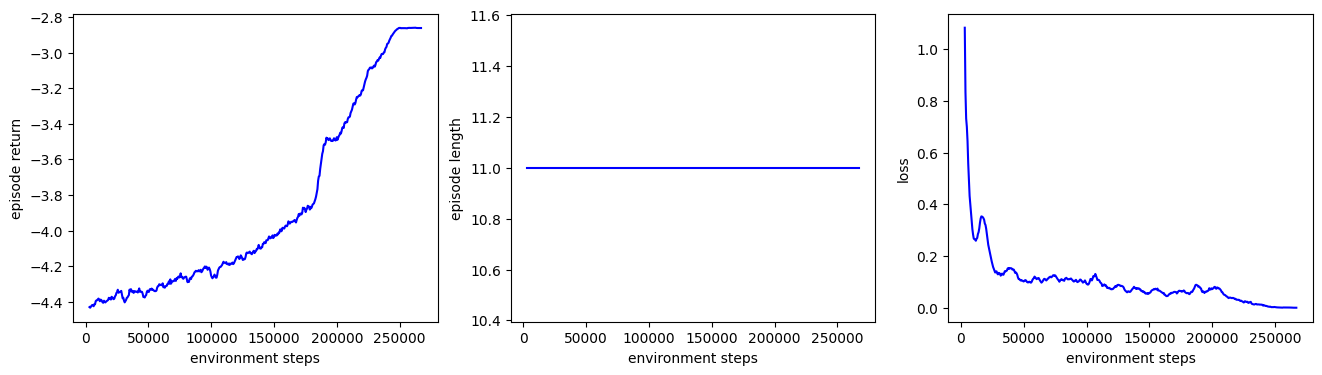

In [11]:
_,_,_,_ = actor_critic_experiment.run()

Tour distance: 2.8593528270721436


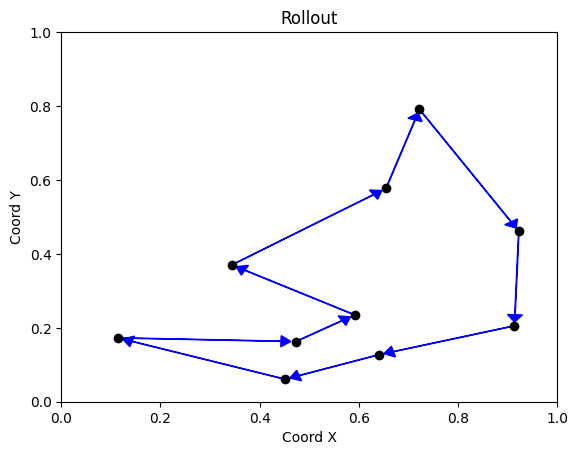

In [12]:
actor_critic_experiment.plot_rollout()

## Off-policy Actor-critic Learner

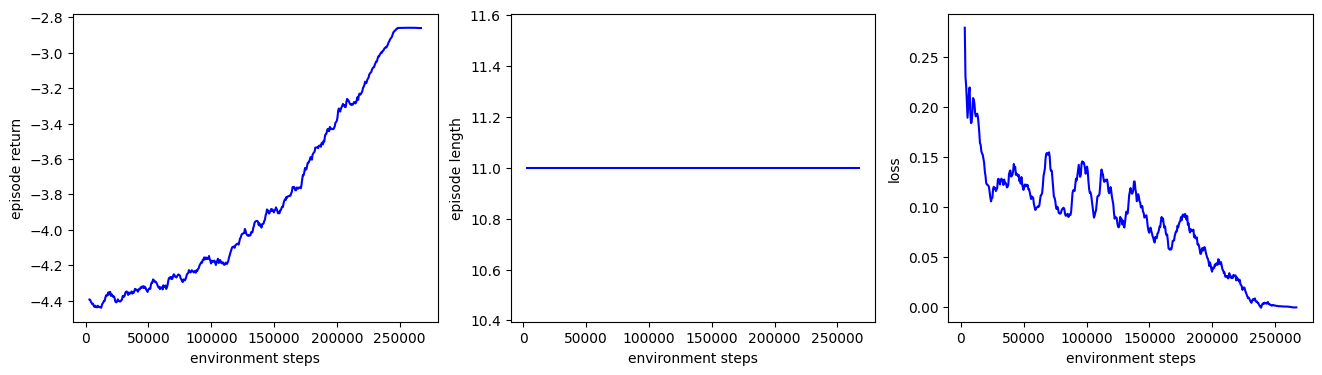

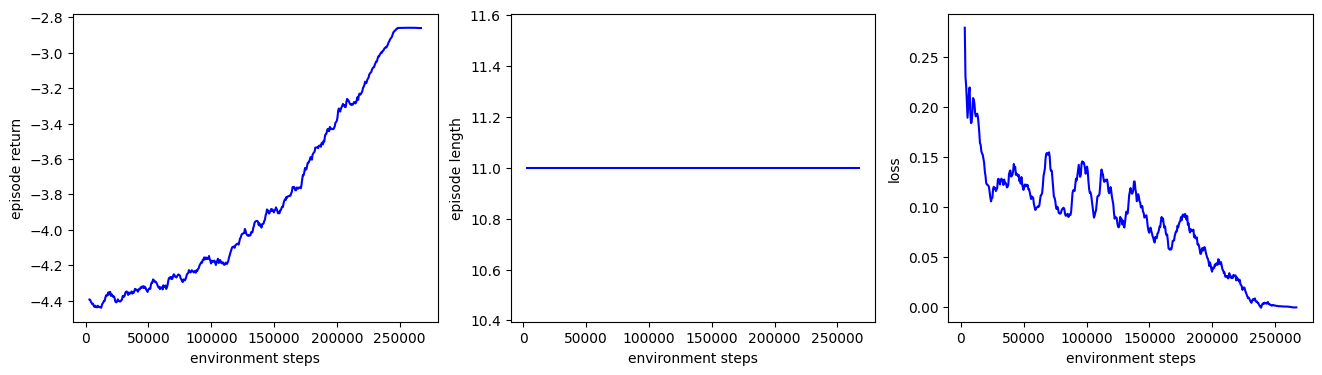

In [13]:
_,_,_,_ = off_policy_actor_critic_experiment.run()

Tour distance: 2.8593528270721436


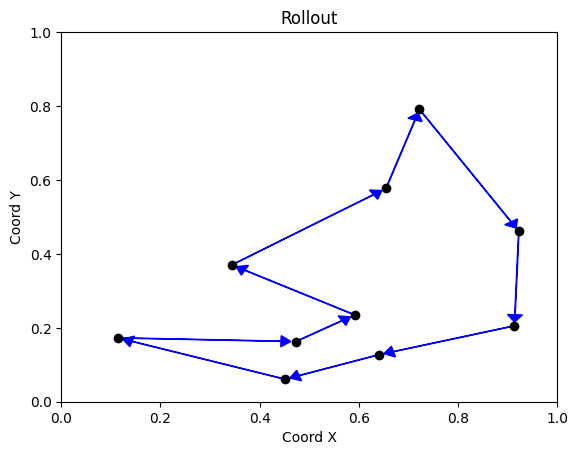

In [14]:
off_policy_actor_critic_experiment.plot_rollout()

## Proximal Policy Optimization Learner

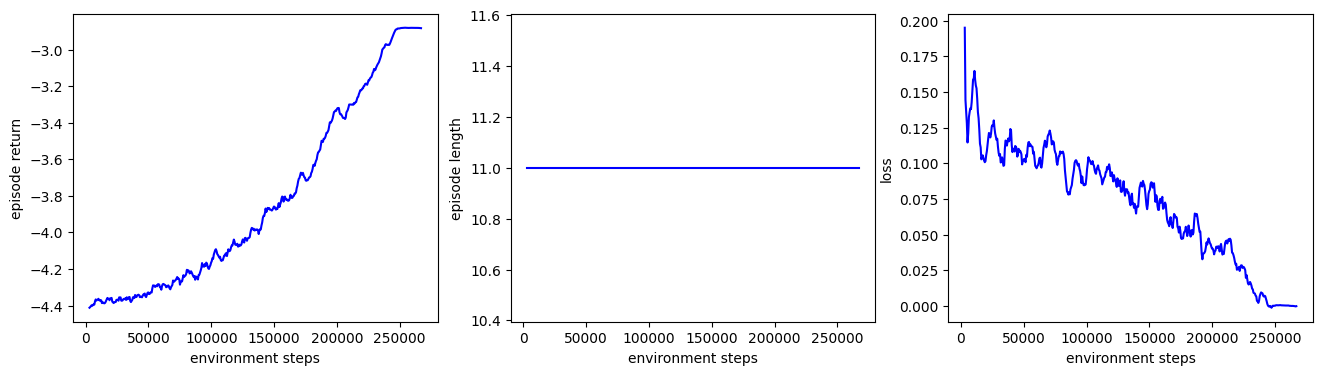

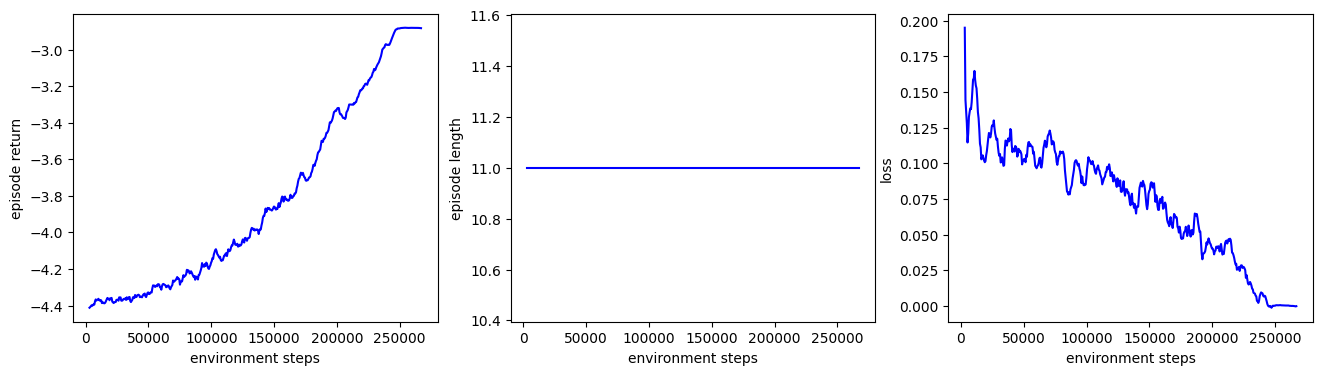

In [15]:
_,_,_,_ = ppo_experiment.run()

Tour distance: 2.882275342941284


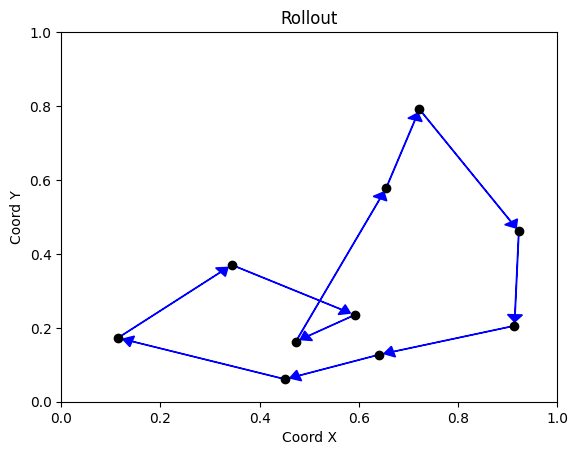

In [16]:
ppo_experiment.plot_rollout()